<h1> <center> Partie 2 - Optimisation sous contrainte

In [2]:
from pulp import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df=pd.read_excel('markowitz_dataset.xlsx')

Pour accéder à un portefeuille, il faut utiliser Var[xi].value() pour connaitre l'investissment en € dans l'actif dont le n°DPE est xi.

In [4]:
returns_min = np.linspace(0, 0.057, 100)
returns = np.zeros_like(returns_min)
z = np.zeros_like(returns_min)
results = np.zeros_like(returns_min)


for j,r in enumerate(returns_min):
    model = pulp.LpProblem('linear_programming', LpMinimize)
    #Déclaration des variables
    Var = dict()
    for i,xi in enumerate(df['N°DPE']):
        Var.setdefault(xi,LpVariable(f"{xi}", lowBound=0))

    #Fonction objective à minimiser
    model += lpSum([Var[xi]*df['Emission_GES_kgCO2_m2_an'][i] for i,xi in enumerate(df['N°DPE'])])

    #Ajout des contraintes
    for i,xi in enumerate(df['N°DPE']):
        model += Var[xi] <= 1e8

    model += lpSum([Var[xi] for i,xi in enumerate(df['N°DPE'])]) == 2e9

    model += lpSum([Var[xi]*df['taux_credit'][i] for i,xi in enumerate(df['N°DPE'])]) >= 2e9*r

    #Résolution
    result = model.solve()
    results[j] = result
    returns[j] = sum([Var[xi].value()*df['taux_credit'][i] for i,xi in enumerate(df['N°DPE'])])/2e9
    z[j] = value(model.objective)/2e9

Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Aug 20 2024 

command line - cbc /var/folders/2n/lg7k599d1vb29gj0p2dj2rfr0000gn/T/7dffb47b6f0e4b35bd9789a05dc7d375-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/2n/lg7k599d1vb29gj0p2dj2rfr0000gn/T/7dffb47b6f0e4b35bd9789a05dc7d375-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 285 COLUMNS
At line 1398 RHS
At line 1679 BOUNDS
At line 1680 ENDATA
Problem MODEL has 280 rows, 278 columns and 834 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 1 (-279) rows, 276 (-2) columns and 276 (-558) elements
0  Obj 0 Primal inf 2e+09 (1)
1  Obj 1.97e+09
Optimal - objective value 1.97e+09
After Postsolve, objective 1.97e+09, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 1970000000 - 1 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0

Text(0, 0.5, 'émission de GES')

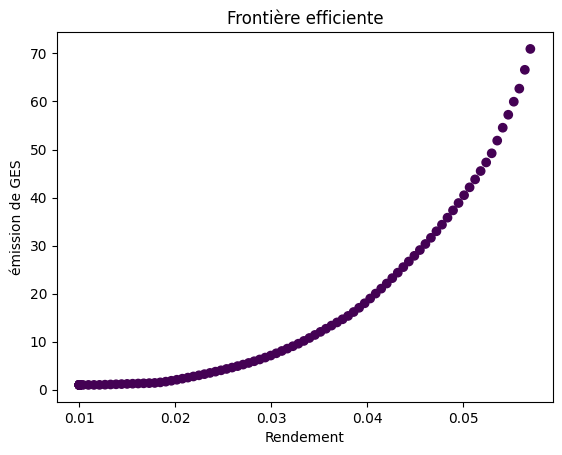

In [5]:
plt.scatter(returns,z, c = results)
plt.title('Frontière efficiente')
plt.xlabel('Rendement')
plt.ylabel('émission de GES')

In [6]:
emissions_max = np.linspace(10, 90, 150)
emissions = np.zeros_like(emissions_max)
z2 = np.zeros_like(emissions_max)
results2 = np.zeros_like(emissions_max)


for j,ges in enumerate(emissions_max):
    model = pulp.LpProblem('linear_programming', LpMaximize)
    #Déclaration des variables
    Var = dict()
    for i,xi in enumerate(df['N°DPE']):
        Var.setdefault(xi,LpVariable(f"{xi}", lowBound=0))

    #Fonction objective à minimiser
    model += lpSum([Var[xi]*df['taux_credit'][i] for i,xi in enumerate(df['N°DPE'])])

    #Ajout des contraintes
    for i,xi in enumerate(df['N°DPE']):
        model += Var[xi] <= 1e8

    model += lpSum([Var[xi] for i,xi in enumerate(df['N°DPE'])]) == 2e9

    model += lpSum([Var[xi]*df['Emission_GES_kgCO2_m2_an'][i] for i,xi in enumerate(df['N°DPE'])]) <= 2e9*ges

    #Résolution
    result = model.solve()
    results2[j] = result
    emissions[j] = sum([Var[xi].value()*df['Emission_GES_kgCO2_m2_an'][i] for i,xi in enumerate(df['N°DPE'])])/2e9
    z2[j] = value(model.objective)/2e9

Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Aug 20 2024 

command line - cbc /var/folders/2n/lg7k599d1vb29gj0p2dj2rfr0000gn/T/e9c811643cd041028ad099dc5d88e99f-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/2n/lg7k599d1vb29gj0p2dj2rfr0000gn/T/e9c811643cd041028ad099dc5d88e99f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 285 COLUMNS
At line 1398 RHS
At line 1679 BOUNDS
At line 1680 ENDATA
Problem MODEL has 280 rows, 278 columns and 834 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 2 (-278) rows, 199 (-79) columns and 398 (-436) elements
Perturbing problem by 0.001% of 0.41853401 - largest nonzero change 5.0329414e-05 ( 0.35835866%) - largest zero change 0
0  Obj -0 Primal inf 2e+09 (1) Dual inf 14.870941 (199)
4  Obj 66484396
Optimal - objective value 66504854
After Postsolve, objective 66504854, infeasibilities - dual 0 (0), primal 0 (0)
Opti

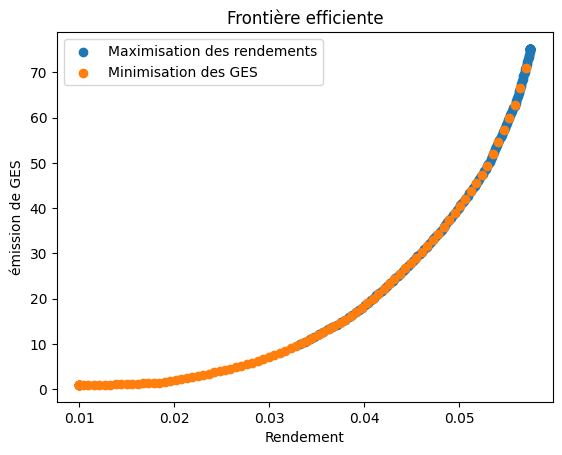

In [7]:
plt.scatter(z2,emissions, label = "Maximisation des rendements")
plt.scatter(returns,z, label = "Minimisation des GES ")
plt.title('Frontière efficiente')
plt.ylabel('émission de GES')
plt.xlabel('Rendement')
plt.legend()
plt.show()